In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import pandas as pd
import bottleneck as bn

## Load Important Function

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [3]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

In [4]:
import numpy as np
from tqdm import tqdm

def calculate_conform_p(trajs, conform_num):
    """
    Calculates the cumulative average population of each conformational state over time,
    excluding NaN values in the trajectory.

    Parameters
    ----------
    trajs : np.ndarray
        A 1D array of shape (timesteps,), where each value is either an integer in 
        [0, conform_num-1] or NaN (for missing data).

    conform_num : int
        The total number of conformational states.

    Returns
    -------
    conform_population : np.ndarray
        Array of shape (conform_num, valid_timesteps) — cumulative average population per conformation.
    """
    trajs = np.asarray(trajs)

    # Only keep valid time steps (non-NaN)
    valid_mask = ~np.isnan(trajs)
    trajs_clean = trajs[valid_mask]
    n_time = trajs_clean.shape[0]

    conform_population = np.zeros((conform_num, n_time), dtype=float)

    for conform_state in range(conform_num):
        match_mask = (trajs_clean == conform_state).astype(float)  # shape: (n_time,)

        cumulative_counts = np.cumsum(match_mask)  # shape: (n_time,)
        time_steps = np.arange(1, n_time + 1)      # shape: (n_time,)

        cumulative_proportions = cumulative_counts / time_steps  # shape: (n_time,)
        conform_population[conform_state] = cumulative_proportions

    #print('Conform population shape:', conform_population.shape)

    return conform_population


## Plot the trans population plot

### Load in the omega angle trajectories by result

In [5]:
# Parameters
residues_to_plot = [0, 1, 2]  # Residues to plot
num_residues = len(residues_to_plot)

omegas_by_result = []  # To store processed omega data
save_dir = 'omega_data'
all_omega = Data.load(f"{save_dir}/data.pkl").array_list  # This is an (742, x, 3) array


In [6]:
print(len(all_omega)) 

all_omega[0].shape
all_omega[0]

742


array([[-173.65106  ,    8.187268 ,  158.7122   ],
       [ 149.942    ,   -5.472654 , -179.34113  ],
       [ 162.98587  ,    2.9294653, -170.57141  ],
       ...,
       [ -25.63846  ,    6.4290886, -142.46432  ],
       [  -1.3674331,   47.98817  , -169.6922   ],
       [ -16.094692 ,   27.522018 ,  177.88043  ]], dtype=float32)

### Convert the Omega into 1 trans and 0 cis


In [7]:
ntraj = len(all_omega)
all_cistrans = []
for i in range(ntraj):
    all_cistrans.append(omega2cistrans(all_omega[i]))

all_cistrans

# Find the longest traj
maxlength = max( [ len(all_cistrans[i]) for i in range(ntraj) ])
print('maxlength', maxlength)

# Make an array to store all the trajectories
traj = np.nan * np.ones( (ntraj, maxlength, 3) )

for i in range(ntraj):
    n = len(all_cistrans[i])
    traj[i, 0:n, :] = all_cistrans[i]

traj.shape

maxlength 196095


(742, 196095, 3)

In [8]:
res_num = 3
res_all_traj = []
for res in range(res_num):
    res_traj = traj[:, :, res]
    res_all_traj.append(res_traj)

res_all_traj = np.array(res_all_traj)
print('res_all_traj.shape', res_all_traj.shape)
res_all_traj[0][1]


res_all_traj.shape (3, 742, 196095)


array([ 0.,  0.,  0., ..., nan, nan, nan])

(0.0, 0.3)

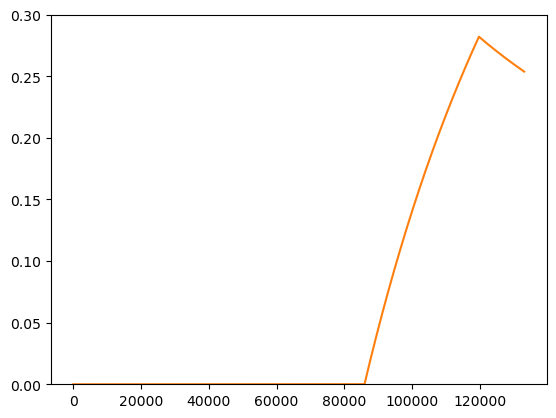

In [9]:
res_all_traj[1][1].shape
conform_num = 2
conform_p = calculate_conform_p(res_all_traj[1][1], conform_num)

plt.plot(conform_p.T)
plt.ylim(0, 0.3)

In [13]:
## Load the refer 

df_stationary_p = pd.read_csv("autocoorel_data/trans_population_at_lagtime.csv")
df_stationary_p['state'] = 0  # or whatever state index it should be
print(df_stationary_p)
    
# Pivot the DataFrame to reshape it
pivot_mean = df_stationary_p.pivot(index='state', columns='res', values='mean')
pivot_std = df_stationary_p.pivot(index='state', columns='res', values='std')

# Convert to NumPy arrays
trans_refer = pivot_mean.to_numpy()  # shape (1, 3) state, residues 
trans_refer_err = pivot_std.to_numpy()  # shape (1, 3)
trans_refer.shape

   res  lagtime_index  lagtime_ns      mean       std  state
0    0             24       201.0  0.725067  0.028305      0
1    1             24       201.0  0.473500  0.107153      0
2    2             24       201.0  0.548286  0.084071      0


(1, 3)

### Plot Average Trans Population of entire 8 states simulation


In [17]:
conform_num = 2
thermal_num = 1
n_traj = res_all_traj.shape[1]
res_num = 3

mean_all_res = []
rmsd_all_res = []

for res in range(res_num):
    # Store population results from each trajectory
    all_conform_populations = []
    res_traj_indexed = res_all_traj[res]

    for i in tqdm(range(n_traj), desc=f"Processing all trajectories for residue {res}"):
        single_traj = res_traj_indexed[i]
        conform_p = calculate_conform_p(single_traj, conform_num)
        all_conform_populations.append(conform_p)

    # Find the longest trajectory (in terms of time steps)
    maxlength = max([cp.shape[1] for cp in all_conform_populations])
    
    #print(f"Residue {res} — Max length: {maxlength}")

    # Stack padded arrays
    all_conform_p = np.full((n_traj, conform_num, maxlength), np.nan)
    for i in range(n_traj):
        time_len = all_conform_populations[i].shape[1]
        all_conform_p[i, :, :time_len] = all_conform_populations[i]
    #print(all_conform_p.shape) #(742, 2, 196095)

    # Select only trans population and normalize
    all_trans_conform_p = all_conform_p[:, 1, :]
    all_cis_conform_p = all_conform_p[:, 0, :]
    total_p = all_trans_conform_p + all_cis_conform_p
    normalized_trans = all_trans_conform_p/total_p
    #print(all_trans_conform_p.shape) #(742, 196095)

    # Select the refer population
    res_trans_refer = trans_refer[:, res]
    res_trans_refer_Err = trans_refer_err[:, res]
    #print(res_trans_refer.shape) #(1,)

    # Calculate MEAN and RMSD
    mean_all_traj = np.nanmean(normalized_trans[:, None, :], axis=0)
    delta_trans_conform_p = np.abs(normalized_trans[:, None, :] - res_trans_refer[None, :, None])
    rmsd_all_traj = np.sqrt(np.nanmean(delta_trans_conform_p**2, axis=0))

    #print(mean_all_traj.shape) #(1, 196095)
    #print(rmsd_all_traj.shape) #(1, 196095)

    mean_all_res.append(mean_all_traj)
    rmsd_all_res.append(rmsd_all_traj)


mean_all_res = np.stack(mean_all_res, axis=0)  # shape: (res_num, 1, maxlength)
rmsd_all_res = np.stack(rmsd_all_res, axis=0)  # same shape
mean_all_res.shape

Processing all trajectories for residue 2: 100%|██████████| 742/742 [00:07<00:00, 98.04it/s] 


(3, 1, 196095)

## Plot for each Res

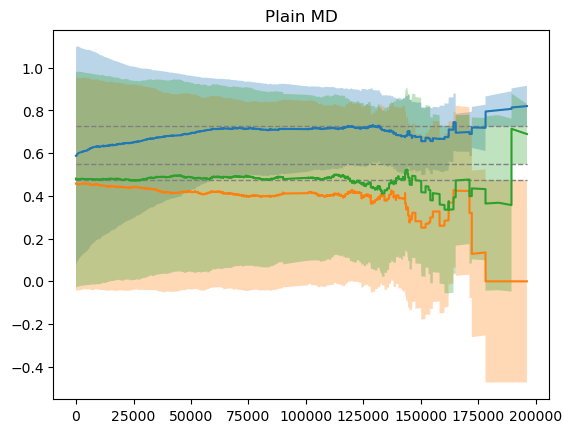

In [28]:
for res in range(res_num):
    
    time = np.arange(mean_all_res.shape[2])
    mean = mean_all_res[res, 0]
    rmsd = rmsd_all_res[res, 0]
    ref = trans_refer[:, res]
    plt.plot(time, mean)
    plt.fill_between(time,
                        mean - rmsd,
                        mean + rmsd,
                        alpha=0.3)
    plt.hlines(y=ref, xmin=time[0], xmax=time[-1], colors='gray', linestyles='--', linewidth=1)
    plt.title(f'Plain MD')
    #plt.ylim(0.4, 0.8)

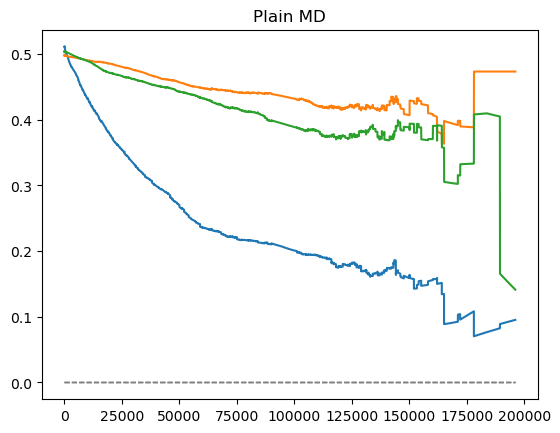

In [29]:
for res in range(res_num):
    
    time = np.arange(mean_all_res.shape[2])
    rmsd = rmsd_all_res[res, 0]
    plt.plot(time, rmsd)
    plt.hlines(y=0, xmin=time[0], xmax=time[-1], colors='gray', linestyles='--', linewidth=1)
    plt.title(f'Plain MD')
    #plt.ylim(0.4, 0.8)